/Users/pavelmanyakin/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[*********************100%%**********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02   28.299999   28.713333   28.114000   28.684000   28.684000   
2020-01-03   29.366667   30.266666   29.128000   29.534000   29.534000   
2020-01-06   29.364668   30.104000   29.333332   30.102667   30.102667   
2020-01-07   30.760000   31.441999   30.224001   31.270666   31.270666   
2020-01-08   31.580000   33.232666   31.215334   32.809334   32.809334   
...                ...         ...         ...         ...         ...   
2024-05-06  183.800003  187.559998  182.199997  184.759995  184.759995   
2024-05-07  182.399994  183.259995  177.399994  177.809998  177.809998   
2024-05-08  171.589996  176.059998  170.149994  174.720001  174.720001   
2024-05-09  175.009995  175.619995  171.369995  171.970001  171.970001   
2024-05-10  173.050003  173.059998  167.750000  168.470001  168.470001   

               Volume  
Date         

[216/300] Loss: 36.7459135055542
[217/300] Loss: 36.51352310180664
[218/300] Loss: 36.27342653274536
[219/300] Loss: 36.03197956085205
[220/300] Loss: 35.77686929702759
[221/300] Loss: 35.5159854888916
[222/300] Loss: 35.25116205215454
[223/300] Loss: 34.97397232055664
[224/300] Loss: 34.69162654876709
[225/300] Loss: 34.40684175491333
[226/300] Loss: 34.11711549758911
[227/300] Loss: 33.82600212097168
[228/300] Loss: 33.53437948226929
[229/300] Loss: 33.243019104003906
[230/300] Loss: 32.94328165054321
[231/300] Loss: 32.660985469818115
[232/300] Loss: 32.376007080078125
[233/300] Loss: 32.095118045806885
[234/300] Loss: 31.82870388031006
[235/300] Loss: 31.56363081932068
[236/300] Loss: 31.312679052352905
[237/300] Loss: 31.05935001373291
[238/300] Loss: 30.821316242218018
[239/300] Loss: 30.60241961479187
[240/300] Loss: 30.380887269973755
[241/300] Loss: 30.18281078338623
[242/300] Loss: 29.982829093933105
[243/300] Loss: 29.7976336479187
[244/300] Loss: 29.61502194404602
[245/300]

[89/165] LossD: 9.703853249549866 LossG:4.853362143039703
[90/165] LossD: 9.704010486602783 LossG:4.852371275424957
[91/165] LossD: 9.703832507133484 LossG:4.853218674659729
[92/165] LossD: 9.703738451004028 LossG:4.85248202085495
[93/165] LossD: 9.703847527503967 LossG:4.852446496486664
[94/165] LossD: 9.703759670257568 LossG:4.852845370769501
[95/165] LossD: 9.703724265098572 LossG:4.852621257305145
[96/165] LossD: 9.703717112541199 LossG:4.852350234985352
[97/165] LossD: 9.703953742980957 LossG:4.852545320987701
[98/165] LossD: 9.703715562820435 LossG:4.853122532367706
[99/165] LossD: 9.70380711555481 LossG:4.852553367614746
[100/165] LossD: 9.703716039657593 LossG:4.852551758289337
[101/165] LossD: 9.703734517097473 LossG:4.851719677448273
[102/165] LossD: 9.70363712310791 LossG:4.853160202503204
[103/165] LossD: 9.703868508338928 LossG:4.852809011936188
[104/165] LossD: 9.703888297080994 LossG:4.852870404720306
[105/165] LossD: 9.703500032424927 LossG:4.852171838283539
[106/165] L

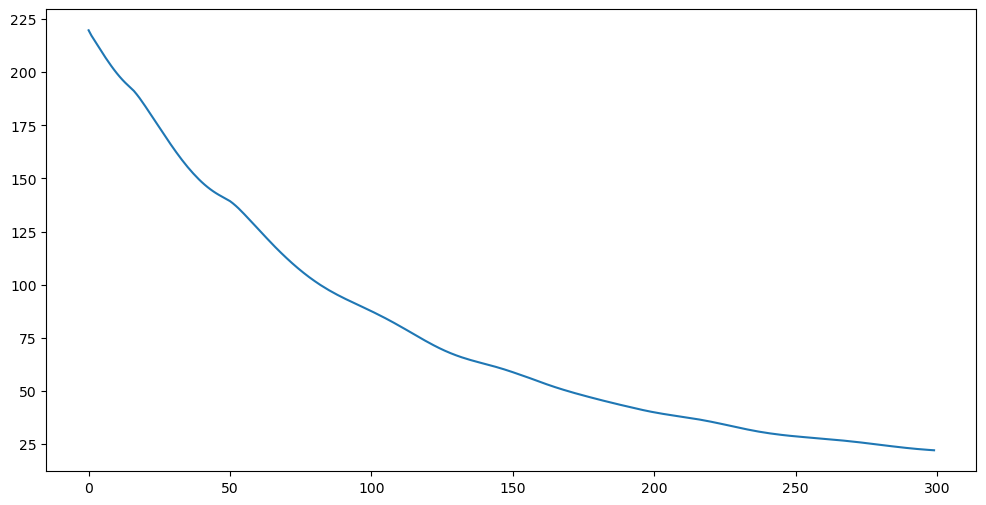

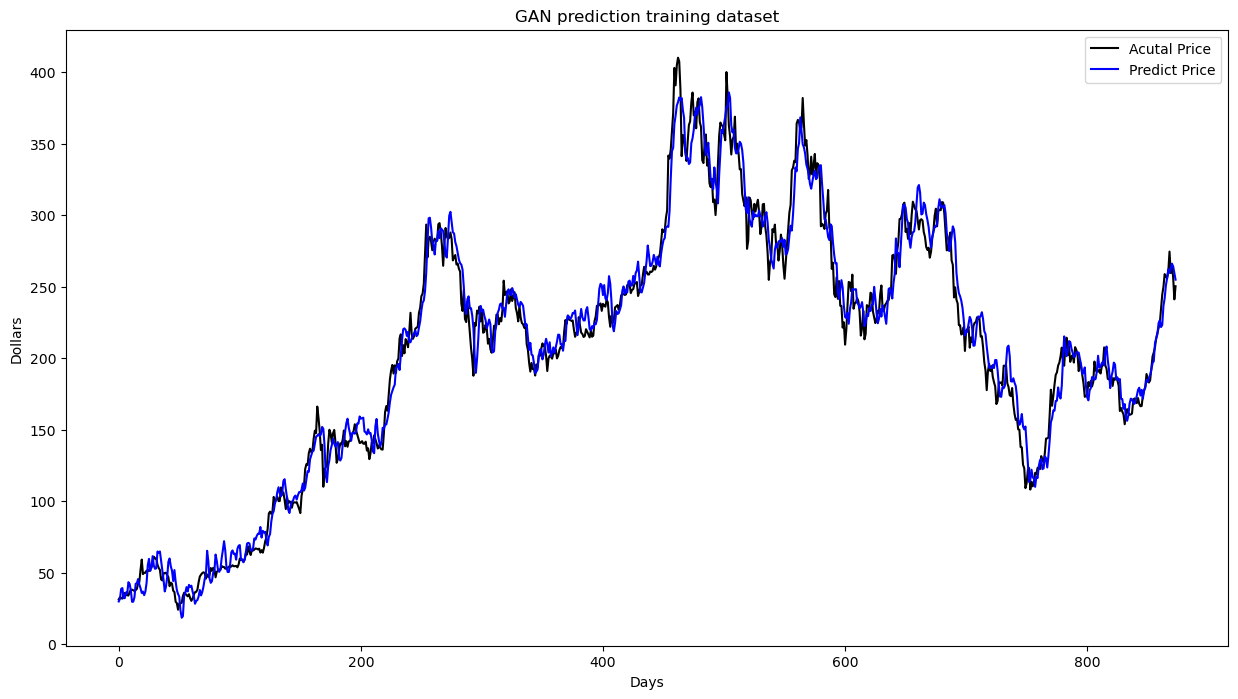

In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
ticker_symbol = 'TSLA'

data = yf.download(ticker_symbol, start="2020-01-01", end=dt.date.today())

print(data)
data['y'] = data['Close'].copy()

x = data.iloc[:, :6].values
y = data.iloc[:, 6].values


split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([6, 100, 100, 100, 10], 10)
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(16).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())
plt.figure(figsize=(15, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('Dollars')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [2]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import matplotlib.pyplot as plt

end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=365)
data = yf.download('TSLA', start=start_date, end=end_date, interval='1h')
data['Close'] = data['Close'].fillna(method='ffill')

x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values
y = data['Close'].values
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(x)
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

def create_dataset(x, time_steps=24):
    x_new = []
    for i in range(time_steps, len(x)):
        x_new.append(x[i-time_steps:i])
    return np.array(x_new)

time_steps = 24
x_new = create_dataset(x_scaled, time_steps)

[*********************100%%**********************]  1 of 1 completed
/var/folders/ml/w52lgnpd681dr_dyz7dhqz9r0000gn/T/ipykernel_49424/455747192.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'] = data['Close'].fillna(method='ffill')


In [5]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

generator = Generator(input_dim=time_steps, hidden_dim=128, output_dim=time_steps)
discriminator = Discriminator(input_dim=time_steps)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

epochs = 200
for epoch in range(epochs):
    for x_batch in train_loader:
        real_data = x_batch[0].view(-1, time_steps)
        real_labels = torch.ones(real_data.size(0), 1)
        fake_labels = torch.zeros(real_data.size(0), 1)

        discriminator.zero_grad()
        outputs = discriminator(real_data)
        real_loss = criterion(outputs, real_labels)

        noise = torch.randn(real_data.size(0), time_steps)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        fake_loss = criterion(outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()

        generator.zero_grad()
        noise = torch.randn(real_data.size(0), time_steps)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')


Epoch [1/200], d_loss: 1.3464103937149048, g_loss: 0.5889703035354614
Epoch [2/200], d_loss: 1.3855400085449219, g_loss: 0.8408003449440002
Epoch [3/200], d_loss: 1.362952470779419, g_loss: 0.8109799027442932
Epoch [4/200], d_loss: 1.2666559219360352, g_loss: 0.8902577757835388
Epoch [5/200], d_loss: 1.2907967567443848, g_loss: 0.7819411754608154
Epoch [6/200], d_loss: 1.2562663555145264, g_loss: 0.7072114944458008
Epoch [7/200], d_loss: 1.3374416828155518, g_loss: 0.8490021228790283
Epoch [8/200], d_loss: 1.374406099319458, g_loss: 0.8039484024047852
Epoch [9/200], d_loss: 1.255817174911499, g_loss: 0.7456659078598022
Epoch [10/200], d_loss: 1.405408263206482, g_loss: 0.6039175391197205
Epoch [11/200], d_loss: 1.382204532623291, g_loss: 0.8243944048881531
Epoch [12/200], d_loss: 1.3711140155792236, g_loss: 0.7164961099624634
Epoch [13/200], d_loss: 1.3700616359710693, g_loss: 0.7010630965232849
Epoch [14/200], d_loss: 1.3936965465545654, g_loss: 0.694666862487793
Epoch [15/200], d_los

Epoch [119/200], d_loss: 1.3698714971542358, g_loss: 0.6986547708511353
Epoch [120/200], d_loss: 1.3690683841705322, g_loss: 0.7686473727226257
Epoch [121/200], d_loss: 1.3960000276565552, g_loss: 0.6654094457626343
Epoch [122/200], d_loss: 1.3803164958953857, g_loss: 0.6800443530082703
Epoch [123/200], d_loss: 1.376977562904358, g_loss: 0.7745590209960938
Epoch [124/200], d_loss: 1.3437471389770508, g_loss: 0.6991857886314392
Epoch [125/200], d_loss: 1.4121177196502686, g_loss: 0.7541024684906006
Epoch [126/200], d_loss: 1.3260419368743896, g_loss: 0.669281542301178
Epoch [127/200], d_loss: 1.4370582103729248, g_loss: 0.7768849730491638
Epoch [128/200], d_loss: 1.3095721006393433, g_loss: 0.7634108662605286
Epoch [129/200], d_loss: 1.413297176361084, g_loss: 0.7080727815628052
Epoch [130/200], d_loss: 1.3788996934890747, g_loss: 0.6676153540611267
Epoch [131/200], d_loss: 1.3321881294250488, g_loss: 0.6805410385131836
Epoch [132/200], d_loss: 1.404529333114624, g_loss: 0.7152084112167

In [10]:
generator.eval()
noise = torch.randn(1, time_steps)
generated_data = generator(noise)
predicted_prices = y_scaler.inverse_transform(generated_data.detach().numpy().reshape(-1, 1))

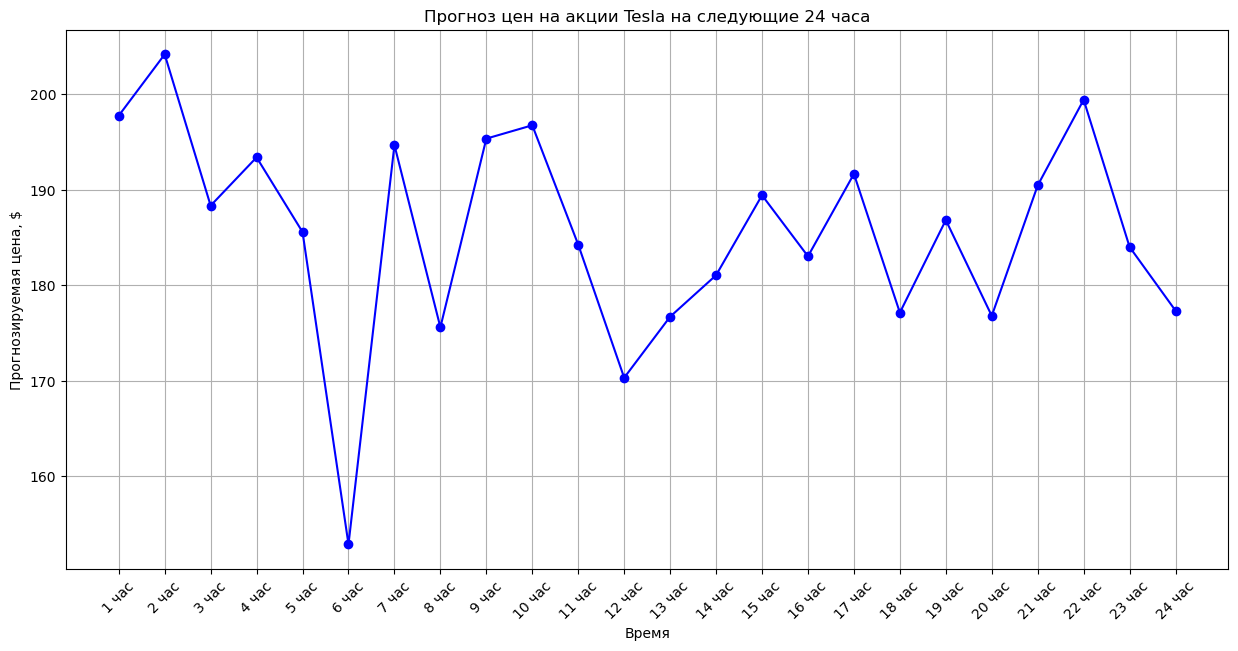

In [11]:
import matplotlib.pyplot as plt

hours = [f"{i+1} час" for i in range(24)]

plt.figure(figsize=(15, 7))
plt.plot(hours, predicted_prices.flatten(), marker='o', linestyle='-', color='blue')
plt.title('Прогноз цен на акции Tesla на следующие 24 часа')
plt.xlabel('Время')
plt.ylabel('Прогнозируемая цена, $')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
